# JS15 — Pipeline Machine Learning & Deployment  
## Praktikum 1 — Klasifikasi Gambar (Day vs Night) dengan Neural Network

Pada praktikum bagian pertama ini, kita akan melatih model dan menyimpan **artefak** (file hasil training) yang dibutuhkan untuk deployment, dengan melakukan klasifikasi gambar **Day vs Night** menggunakan **Neural Network**.


### Unduh Dataset
Jalankan cell berikut untuk mengunduh dan mengekstrak dataset `images.zip` (folder `images/`).

In [1]:
import os, gdown, zipfile
if not os.path.isdir('./images'):
    gdown.download(id='1KZahLtkTW6fpcY60lAMCanRJ_HOFqZcK', output='images.zip')
    with zipfile.ZipFile('images.zip', 'r') as zip_ref:
        zip_ref.extractall()
    os.remove('images.zip')

## Langkah 1: Import Library dan Mount Google Drive

Langkah pertama adalah mengimpor pustaka yang diperlukan untuk pengolahan citra, machine learning, dan deep learning, serta menghubungkan Google Colab dengan Google Drive.

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Langkah 2: Load Dataset

 Membaca gambar dari direktori training dan testing, lalu menyimpannya dalam list bersama dengan labelnya.

**Catatan:** Sesuaikan path dengan lokasi folder `images` di Google Drive Anda masing-masing.

In [3]:
# Load images and labels from a directory structure
def load_dataset(img_dir):
    p = Path(img_dir)
    img_list = []
    for folder in p.glob('*'):
        label = folder.name
        for file in folder.glob('*.jpg'):
            img = cv2.imread(str(file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_list.append((img, label))
    return img_list

train_dir = "/content/images/training/"
test_dir  = "/content/images/test"

train_img = load_dataset(train_dir)
test_img  = load_dataset(test_dir)

print(f"Jumlah data training: {len(train_img)}")
print(f"Jumlah data testing: {len(test_img)}")

Jumlah data training: 240
Jumlah data testing: 160


## Langkah 3: Preprocessing (Resize & Label Encoding)

Mengubah ukuran gambar menjadi 256x256 piksel dan mengubah label teks ('day'/'night') menjadi angka biner (1/0).

In [4]:
# Preprocess images: resize and encode labels
def resize_image(img, size=(256,256)):
    return cv2.resize(img, size)

def label_encoder(label):
    return 1 if label == 'day' else 0

def preprocess(img_list):
    X = []
    y = []
    for img, label in img_list:
        img_std = resize_image(img)
        X.append(img_std)
        y.append(label_encoder(label))
    return X, y

X_train_img, y_train = preprocess(train_img)
X_test_img,  y_test  = preprocess(test_img)

## Langkah 4: Ekstraksi Fitur HOG (Histogram of Oriented Gradients)

Mengekstraksi fitur bentuk dan tekstur dari gambar menggunakan metode HOG.

In [5]:
# Extract HOG features
def extract_hog(X_imgs):
    feats = []
    for img in X_imgs:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hog_feat = hog(gray,
                       orientations=9,
                       pixels_per_cell=(8,8),
                       cells_per_block=(2,2),
                       block_norm='L2-Hys',
                       visualize=False,
                       feature_vector=True)
        feats.append(hog_feat)
    return np.array(feats)

X_train_feat = extract_hog(X_train_img)
X_test_feat  = extract_hog(X_test_img)

## Langkah 5: Normalisasi Fitur

Menstandarisasi fitur agar memiliki rata-rata 0 dan variansi 1 menggunakan `StandardScaler`.

In [6]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_test_scaled  = scaler.transform(X_test_feat)

## Langkah 6: Split Data Training & Validation

Memisahkan data training menjadi data train dan validation.

In [7]:
# Split training data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_scaled, y_train,
    test_size=0.2,
    random_state=42
)

## Langkah 7: Konversi Label ke Numpy Array

Mengubah list label menjadi format numpy array agar kompatibel dengan TensorFlow/Keras.

In [8]:
# Convert labels to numpy arrays (required for Keras)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

## Langkah 8: Membangun Arsitektur Model Neural Network

Membuat model Sequential dengan 3 layer (Input, Hidden Layers dengan ReLU, dan Output Layer dengan Sigmoid).

In [9]:
# Build a simple feedforward neural network
# Define model architecture
# input_dim is the number of features in the dataset
# Hidden layer -> 128 neurons, ReLU activation
# Hidden layer -> 64 neurons, ReLU activation
# Output layer -> 1 neuron, Sigmoid activation (for binary classification)

input_dim = X_train.shape[1]
model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     4,428,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,436,737 (16.92 MB)

 Trainable params: 4,436,737 (16.92 MB)

 Non-trainable params: 0 (0.00 B)

## Langkah 9: Training Model

Melatih model menggunakan data training selama 20 epoch.

In [10]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.6825 - loss: 1.0231 - val_accuracy: 0.9792 - val_loss: 0.0365
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 0.0376
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9965 - loss: 0.0063 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 1.0000 - loss: 9.5070e-05 - val_accuracy: 0.9583 - val_loss: 0.0521
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 2.8319e-05 - val_accuracy: 1.0000 - val_loss: 7.9151e-04
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.7872e-06 - val_accuracy: 1.0000 - val_loss: 3.1273e-04
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 3.2672e-06 - val_accuracy: 1

## Langkah 10: Evaluasi Model

Menguji performa model pada data testing.

In [11]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print("Akurasi Test:", test_acc)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9011 - loss: 0.5256
Akurasi Test: 0.8999999761581421


## Langkah 11: Prediksi dan Laporan Klasifikasi serta Visualisasi

Membuat prediksi pada data test dan menampilkan classification report serta confusion matrix.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
              precision    recall  f1-score   support

           0       0.93      0.86      0.90        80
           1       0.87      0.94      0.90        80

    accuracy                           0.90       160
   macro avg       0.90      0.90      0.90       160
weighted avg       0.90      0.90      0.90       160

[[69 11]
 [ 5 75]]


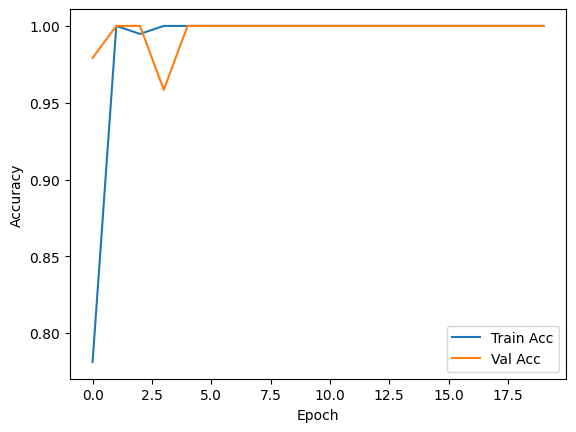

In [12]:
# Generate classification report and confusion matrix
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Visualize training history
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Langkah 12: Menyimpan Model dan Scaler

Menyimpan model yang sudah dilatih ke dalam format `.h5` dan scaler ke format `.pkl` untuk penggunaan deployment.

In [13]:
# Save the trained model
import pickle

# 1. Simpan Model
# Menggunakan format .h5
model.save('day_night_model.h5')
print("✅ Model berhasil disimpan sebagai: day_night_model.h5")

# 2. Simpan Scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler berhasil disimpan sebagai: scaler.pkl")

✅ Model berhasil disimpan sebagai: day_night_model.h5
✅ Scaler berhasil disimpan sebagai: scaler.pkl
